# Data Cuts

This notebook explores the impact on data cuts.


In [1]:
from collections import OrderedDict
from pathlib import Path
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.cosmology import WMAP9 as wmap9
from matplotlib.ticker import MultipleLocator
from scipy.stats.stats import pearsonr
from sndata.csp import DR3
from sndata.sdss import Sako18Spec
from sndata.utils import convert_to_jd

from utils import read_in_pipeline_result


In [2]:
curr_dir = Path('.').resolve() 
results_dir = curr_dir.parent / 'results'

csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', 'csp', drop_flagged=True)
sdss_final = read_in_pipeline_result(results_dir / 'final_sdss.csv', 'sdss', drop_flagged=True)


In [3]:
feature_alias = {
    'pW1': 'Ca ii H&K',
    'pW2': 'Si ii λ4130',
    'pW3': 'Mg ii, Fe ii',
    'pW4': 'Fe ii, Si ii',
    'pW5': 'S ii λ5449, λ5622',
    'pW6': 'Si ii λ5972',
    'pW7': 'Si ii λ6355',
    'pW8': 'Ca ii IR triplet'}


## Number of Measurements

In [4]:
def plot_number_feature_measurements(measured_data, hist_col=None, xlocator=1):
    """Plot a histogram of the number of measurements performed for each feature
    
    Args:
        measured_data (DataFrame): The measured data
        hist_col            (str): Name of the column to plot as the histogram
        xlocator          (float): Show xaxis tick marks as a multiple of this number
    """
    
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5))
    for (feature, data), axis in zip(measured_data.groupby(level=0), axes.flatten()):
        counts = data.index.value_counts() if hist_col is None else data[hist_col]
        axis.hist(counts, align='mid')
        axis.xaxis.set_major_locator(MultipleLocator(xlocator))
        axis.set_title(f'{feature_alias[feature]}')
        
    for axis in axes[:, 0]:
        axis.set_ylabel('Number of Objects')

    for axis in axes[-1]:
        xlabel = hist_col or 'Number of Measurements'
        axis.set_xlabel(xlabel)


Text(0.5, 0.98, 'Number of CSP Feature Measurements per Phase')

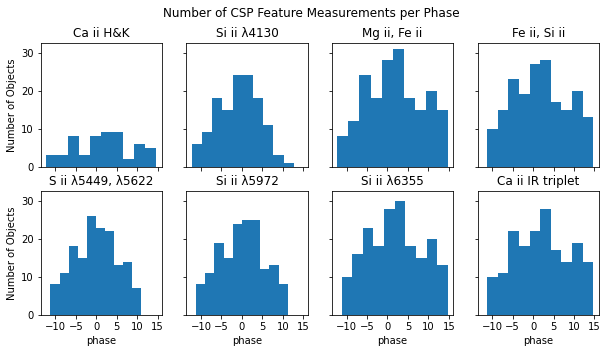

In [5]:
plot_number_feature_measurements(csp_final, 'phase', 5)
plt.gcf().suptitle('Number of CSP Feature Measurements per Phase')


Text(0.5, 0.98, 'Number of SDSS Feature Measurements per Phase')

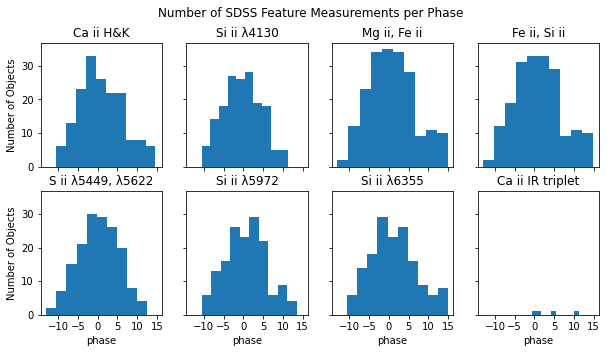

In [6]:
plot_number_feature_measurements(sdss_final, 'phase', 5)
plt.gcf().suptitle('Number of SDSS Feature Measurements per Phase')


Text(0.5, 0.98, 'Number of CSP Feature Measurements')

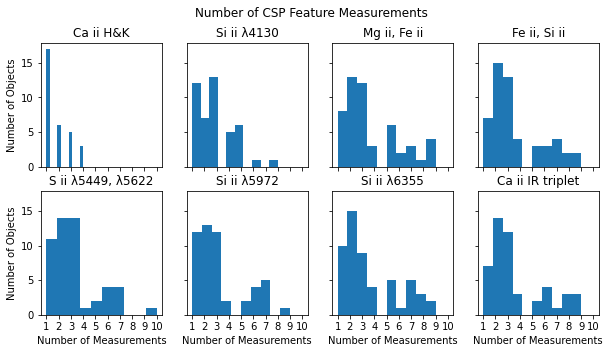

In [7]:
plot_number_feature_measurements(csp_final)
plt.gcf().suptitle('Number of CSP Feature Measurements')


Text(0.5, 0.98, 'Number of SDSS Measurements per Feature')

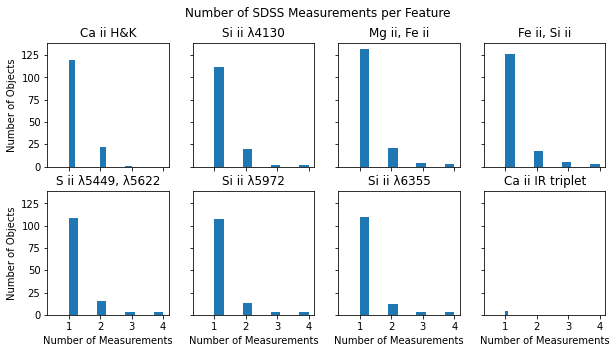

In [8]:
plot_number_feature_measurements(sdss_final)
plt.gcf().suptitle('Number of SDSS Measurements per Feature')


## Effect of Data Cuts

In [9]:
def plot_impact_of_phase_cut(measured_data, cutoff_vals, chosen_cutoff):
    """Plot the cumulative total number of measurements within a given number
    of days from maximum
    
    Args:
        measured_data (DataFrame): The measured data
        cutoff_vals        (List): Values to plot on x-axis in units of days
    """
    
    phase_abs = measured_data.phase.abs()
    
    fig, axis = plt.subplots(figsize=(10, 5))
    for feature, data in phase_abs.groupby(level=0):
        y_vals = [len(data[data <= c].index.unique(level=1)) for c in cutoff_vals]
        y_cutoff = len(data[data <= chosen_cutoff].index.unique(level=1))
        axis.plot(cutoff_vals, y_vals, label=f'{feature} ({y_cutoff})')
    
    axis.axvline(proposed_cutoff, color='k', linestyle='--')
    axis.set_ylabel('Number of Objects')
    axis.set_xlabel('Phase Cutoff')
    axis.set_xlim(min(cutoff_vals), max(cutoff_vals))
    axis.set_ylim(0)
    axis.legend()
        

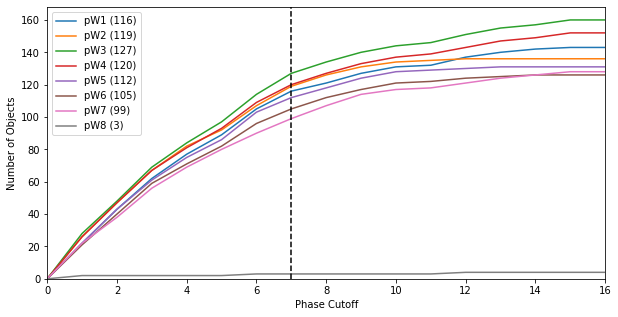

In [10]:
proposed_cutoff = 7
plot_impact_of_phase_cut(sdss_final, np.arange(16, -1, -1), proposed_cutoff)



In [11]:
def cutoff_histogram(pipeline_data, hist_col, cutoff, xlabel=None, figsize=(4, 4)):
    """Plot overlapping histograms for kept and dropped data
    
    Args:
        pipeline_data (DataFrame): Data from a pipeline output file
        hist_col            (str): Column name to use for histogram data
        cutoff            (float): Phase cutoff used to drop data
        xlabgel             (str): Optional xaxis label (defaults to xcol)
        figsize           (Tuple): Size of the figure in inches
    """
    
    pipeline_data = pipeline_data[pipeline_data.is_peak]
    
    kept_data = pipeline_data[pipeline_data.delta_t <= cutoff][hist_col]
    dropped_data = pipeline_data[pipeline_data.delta_t > cutoff][hist_col]
    
    fig, axis = plt.subplots(figsize=figsize)
    axis.hist(kept_data)
    axis.hist(dropped_data, histtype='step', hatch='//', linewidth=2)
    
    axis.set_xlabel(xlabel or hist_col)
    axis.set_ylabel('Number of Objects')


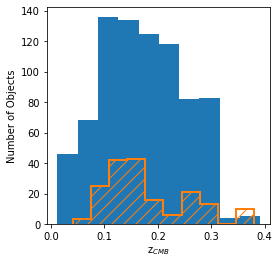

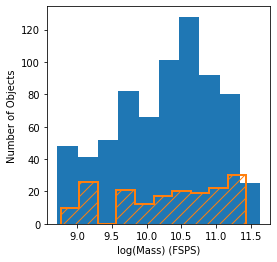

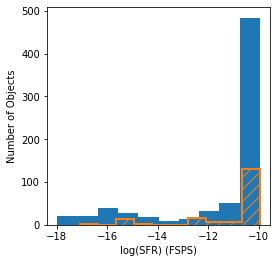

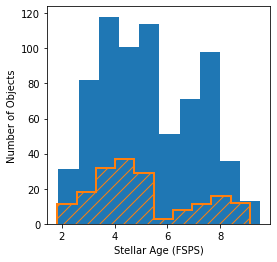

In [12]:
colnames = ['zCMB', 'logMassFSPS', 'logSSFRFSPS', 'ageFSPS']
xlabels = [r'z$_{CMB}$', r'log(Mass) (FSPS)', r'log(SFR) (FSPS)', r'Stellar Age (FSPS)']

for col, xl in zip(colnames, xlabels):
    cutoff_histogram(sdss_final, col, 7, xl)


In [13]:
branch_outliers = ['10449', '16021', '1371', '6773', '7147', '16099', 
                   '16281', '18375', '18697', '21502']

In [ ]:
#outliers from branch plot
branch_outliers = ['10449', '16021', '1371', '6773', '7147', '16099', 
                   '16281', '18375', '18697', '21502']
redshift_outliers = ['16280', '3901', '17825', '2330', '1580', '15369', '13072', '5737', '5994', '16287',
                     '6422', '6933', '16333']
hostmass_outliers = ['16280', '3901', '2330', '1580', '15369', '6422', '13072', '16333']
sfr_outliers = ['1580', '1253', '20350', '16280', '16333']